In [26]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

In [27]:
dataset_path = "./Downloads/Leaves"
os.listdir(dataset_path)

['Ash', 'Beech', 'Hornbeam', 'Mountain oak', 'Sycamore maple', 'mytests']

In [28]:
import joblib
from skimage.io import imread
from skimage.transform import resize, rotate

def imagesInArrays(src, pklname, include, width=150,height=None):
    height = height if height is not None else width

    data = dict()
    data["description"] = "resized ({0}x{1}) leaf images in rgb".format(int(width), int(height))
    data["label"] = []
    data["filename"] = []
    data["data"] = []

    pklname = f"{pklname}_{width}x{height}px.pkl"

    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)

            for file in os.listdir(current_path):
                if file[-3:] in {"JPG", "jpg"}: #Just in case
                    print(file)
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width,height))
                    for i in range(36):
                        #Creating rotated copies of the image
                        data["label"].append(subdir)
                        data["filename"].append(file)
                        data["data"].append(rotate(im,10*i))
        joblib.dump(data,pklname)

In [29]:
base_name = "leaf_species"
include = {'Ash','Beech', 'Hornbeam', 'Mountain oak', 'Sycamore maple'}
width = 80
imagesInArrays(src=dataset_path, include=include, pklname=base_name, width=width)

Ash
PA253597.JPG
PA253598.JPG
PA253599.JPG
PA253600.JPG
PA253601.JPG
PA253602.JPG
PA253603.JPG
PA253604.JPG
PA253605.JPG
PA253606.JPG
PA253607.JPG
PA253609.JPG
PA253610.JPG
PA253611.JPG
PA253612.JPG
PA253613.JPG
PA253614.JPG
PA253615.JPG
PA253616.JPG
PA253617.JPG
PA253618.JPG
PA253619.JPG
PA253620.JPG
PA253621.JPG
Beech
_OBF1969.JPG
_OBF1970.JPG
_OBF1971.JPG
_OBF1972.JPG
_OBF1973.JPG
_OBF1974.JPG
_OBF1975.JPG
_OBF1976.JPG
_OBF1977.JPG
_OBF1978.JPG
_OBF1979.JPG
_OBF1980.JPG
_OBF1981.JPG
_OBF1982.JPG
_OBF1984.JPG
_OBF1985.JPG
_OBF1986.JPG
_OBF1987.JPG
_OBF1988.JPG
_OBF1989.JPG
_OBF1990.JPG
_OBF1991.JPG
_OBF1992.JPG
_OBF1993.JPG
_OBF1994.JPG
_OBF1995.JPG
_OBF1996.JPG
_OBF1997.JPG
Hornbeam
20091027_2074.JPG
20091027_2075.JPG
20091027_2076.JPG
20091027_2077.JPG
20091027_2078.JPG
20091027_2079.JPG
20091027_2080.JPG
20091027_2081.JPG
20091027_2082.JPG
20091027_2083.JPG
20091027_2084.JPG
20091027_2085.JPG
20091027_2086.JPG
20091027_2087.JPG
20091027_2088.JPG
20091027_2089.JPG
20091027_2090.JPG

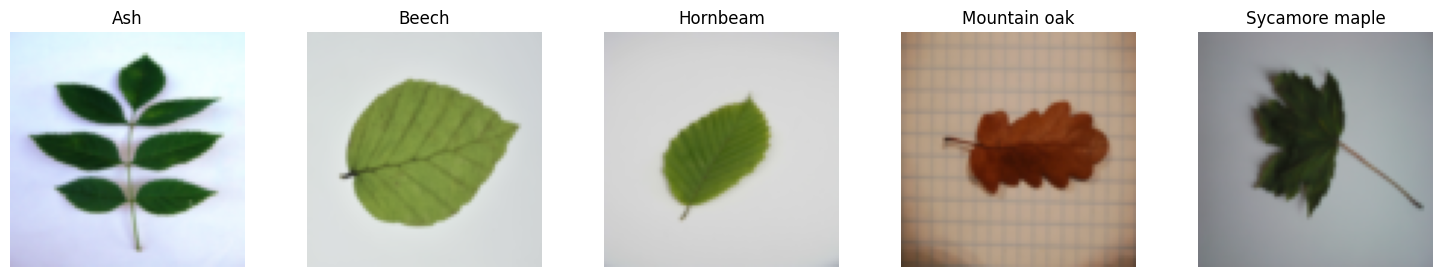

In [30]:
data = joblib.load(f"{base_name}_{width}x{width}px.pkl")
labels = np.unique(data["label"])
fig, axes = plt.subplots(1,len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
i = 0
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [31]:
X = np.array(data["data"])
y = np.array(data["label"])

In [32]:
#Shuffle data, so the test data isn't just one species
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

In [33]:
#Transformers
#Just an object that take in an array of dta, transform each item and return the result (like a stream?)
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])

class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8,8),
                 cells_per_block=(3,3),
                 block_norm="L2-Hys"):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
    def fit(self,X,y=None):
        return self
    def transform(self, X, y=None):
        def local_hog(X):
            return hog(X,
                       orientations = self.orientations,
                       pixels_per_cell = self.pixels_per_cell,
                       cells_per_block = self.cells_per_block,
                       block_norm = self.block_norm)
        try:
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage

#instantiating our transformers
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14,14),
    cells_per_block=(2,2),
    orientations=9,
    block_norm="L2-Hys"
)
scalify = StandardScaler()

X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

print(X_train_prepared.shape)

(3513, 576)


In [35]:
#Stochastic gradient descent
sgd_clf = SGDClassifier(random_state=41, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared,y_train)

SGDClassifier(random_state=41)

In [36]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [37]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test))
print("")
print("Percentage correct: ", 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

Beech
beech3.jpg
beech2.jpg
beech4.jpg
Hornbeam
hornbeam1.jpg
['Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam'
 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Sycamore maple' 'Hornbeam' 'Hornbeam'
 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam'
 'Hornbeam' 'Sycamore maple' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam'
 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam'
 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam' 'Hornbeam'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycamore maple' 'Sycamore maple'
 'Sycamore maple' 'Sycamore maple' 'Sycam

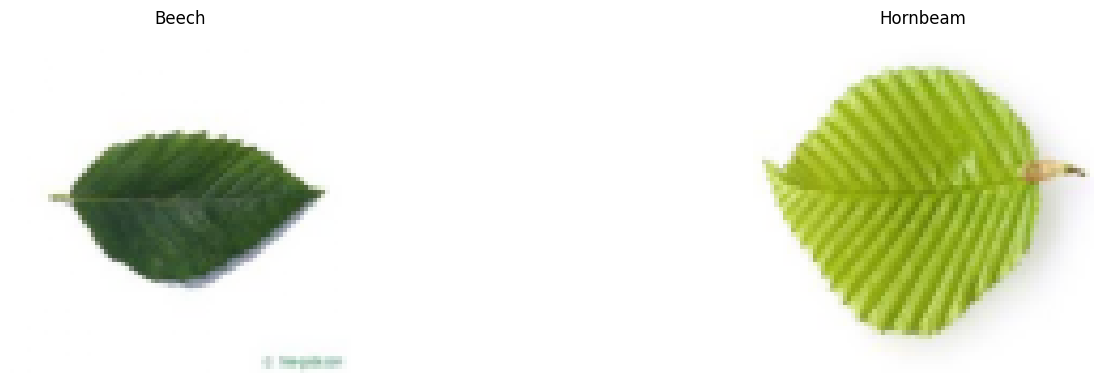

In [43]:
def tryMyOwn():
    my_test_path = "./Downloads/Leaves/mytests"
    base_name = "leaf_species_tests"
    include = {'Beech','Hornbeam'}#'Palm',"Ash","Sycamore Maple"}
    width = 80
    imagesInArrays(src=my_test_path, include=include, pklname=base_name, width=width)
    data = joblib.load(f"{base_name}_{width}x{width}px.pkl")
    labels = np.unique(data["label"])

    fig, axes = plt.subplots(1,len(labels))
    fig.set_size_inches(15,4)
    fig.tight_layout()
    i = 0
    for ax, label in zip(axes, labels):
        idx = data['label'].index(label)
         
        ax.imshow(data['data'][idx])
        ax.axis('off')
        ax.set_title(label)
    
    X = np.array(data["data"])
    y = np.array(data["label"])
    transformed_tests = scalify.transform((hogify.transform(grayify.transform(X))))
    print(sgd_clf.predict(transformed_tests))
tryMyOwn()